In [15]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

client = MongoClient('localhost:27017')
db = client.hiwi
collection = db.production_steps

database = {}
database['features'] = {}
index = []

query_1 = {"$and": [{"type": "crino_eol"}, {"substep": "qdot"}, {"features": {"$exists": True}}]}
query_1 = list(collection.find(query_1))
database['features']['qdot_after_24h'] = []
database['features']['qdot_continuity'] = []

for i in range(len(query_1)):
    database['features']['qdot_after_24h'].append(query_1[i]['features'][0]['value'])
    database['features']['qdot_continuity'].append(query_1[i]['features'][1]['value'])
    index.append(query_1[i]['cell_id'])

data = pd.DataFrame(database['features'])

class_le = LabelEncoder()
for column in data[['qdot_continuity']].columns:
    data[column] = class_le.fit_transform(data[column].values)
# get all features and store them into dataframe


Text(0, 0.5, 'Cumulative Explained Variance')

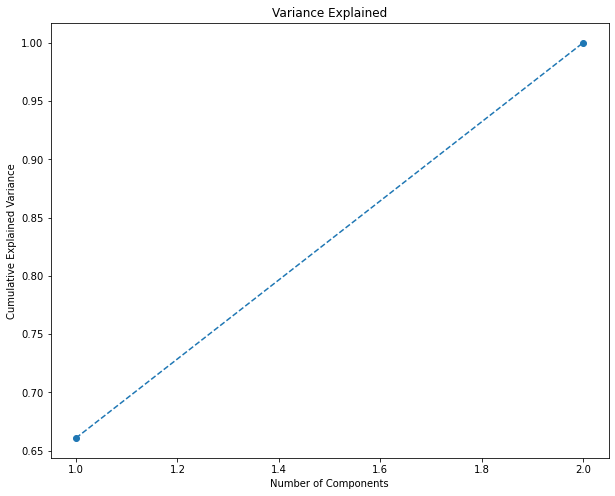

In [16]:
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(data)

pca = PCA()
pca.fit(segmentation_std)

plt.figure(figsize=(10,8))
plt.plot(range(1,3), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
# select number of components that VAR higher than 0.8

In [17]:
# from above we select 2
pca = PCA(n_components=2)
pca.fit(segmentation_std)
scores_pca = pca.transform(segmentation_std)

data_pca = pd.concat([data.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
data_pca.columns.values[-2: ] = ['Component 1', 'Component 2']
data = data_pca[['Component 1', 'Component 2']]
data.head()
# now we have new representation of all original features, they are highly abstract and not correlated to each other

,Component 1,Component 2
0,-0.543253,0.229076
1,-0.524907,0.247421
2,-0.535132,0.237197
3,-0.496522,0.275807
4,-0.548436,0.223893


In [ ]:
# below is showing how to find potential pattern of data (e.g. alive, dead, abnormal etc.)
# the basical idea is to find the labels for each step (formation/conditioning/raw_v/raw_q). 
# we already have final label of raw_q, but since I'm not expert of batteries, I cannot define them now
# if later you can define the label for batteries for all steps then you can just ignore the underlining codes

Text(0, 0.5, 'WCSS')

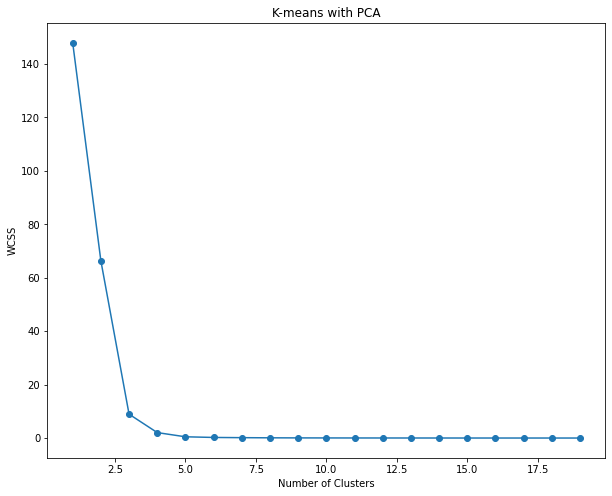

In [18]:
wcss = []
for i in range(1,20): # grid search, assume we have 1 or 2 or 3 ... or 20 clusters/patterns
  kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
  kmeans_pca.fit(scores_pca)
  wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(10,8))
plt.plot(range(1,20), wcss, marker='o', linestyle='-')
plt.title('K-means with PCA')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
# select Number of Clusters that before curve becomes very flat

In [19]:
kmeans_pca = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)

data['Segment K-means PCA'] = kmeans_pca.labels_
data.head()

<ipython-input-19-f7c49071e871>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Segment K-means PCA'] = kmeans_pca.labels_


,Component 1,Component 2,Segment K-means PCA
0,-0.543253,0.229076,0
1,-0.524907,0.247421,0
2,-0.535132,0.237197,0
3,-0.496522,0.275807,0
4,-0.548436,0.223893,0


/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


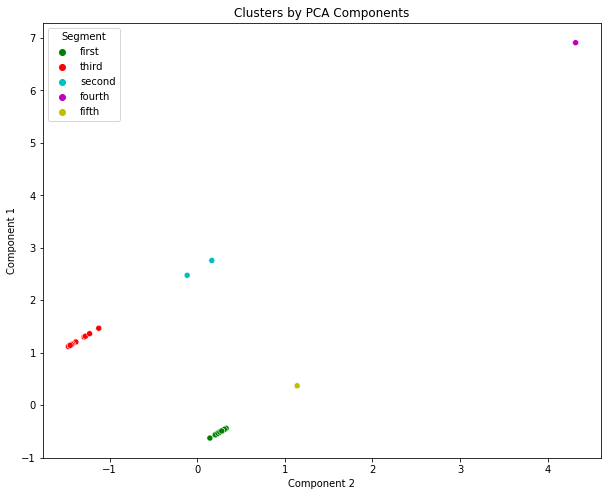

In [22]:
data['Segment'] = data['Segment K-means PCA'].map({0:'first',1:'second',2:'third',3:'fourth',4:'fifth'})
x_axis = data['Component 2']
y_axis = data['Component 1']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis, y_axis, hue = data['Segment'], palette = ['g','r','c','m','y'])
plt.title('Clusters by PCA Components')
plt.show()

In [23]:
crino = {'index': index, 'label': kmeans_pca.labels_}
crino = pd.DataFrame(crino, columns = ['index','label'])
crino = crino.sort_values(by = ['index'])
crino.to_csv('Raw_q_PCA_Kmeans_label.csv') 
crino.head()

,label
Q_248,0
Q_229,0
Q_171,0
Q_239,0
Q_249,0


In [25]:
label = crino['label'].tolist()
class_0, class_1, class_2, class_3, class_4 = [], [], [], [], []

for i in range(len(label)):
    if label[i] == 0:
        class_0.append(index[i])
    if label[i] == 1:
        class_1.append(index[i])
    if label[i] == 2:
        class_2.append(index[i])
    if label[i] == 3:
        class_3.append(index[i])
    if label[i] == 4:
        class_4.append(index[i])

print('class_0:', class_0)
print('class_1:',class_1)
print('class_2:',class_2)
print('class_3:',class_3)
print('class_4:',class_4)

class_0: ['Q_248', 'Q_229', 'Q_171', 'Q_239', 'Q_249', 'Q_235', 'Q_183', 'Q_240', 'Q_172', 'Q_241', 'Q_182', 'Q_234', 'Q_209', 'Q_245', 'Q_190', 'Q_224', 'Q_163', 'Q_238', 'Q_214', 'Q_208', 'Q_210', 'Q_236', 'Q_221', 'Q_180', 'Q_181', 'Q_242', 'Q_237', 'Q_213', 'Q_165', 'Q_173', 'Q_189', 'Q_233', 'Q_247', 'Q_195', 'Q_184', 'Q_246', 'Q_177', 'Q_169', 'Q_176', 'Q_199', 'Q_198', 'Q_220', 'Q_216', 'Q_192', 'Q_222', 'Q_207', 'Q_193', 'Q_205', 'Q_217', 'Q_174', 'Q_187', 'Q_179', 'Q_201', 'Q_244', 'Q_186', 'Q_197']
class_1: ['Q_250', 'Q_200']
class_2: ['Q_168', 'Q_219', 'Q_162', 'Q_227', 'Q_202', 'Q_185', 'Q_191', 'Q_243', 'Q_170', 'Q_204', 'Q_188', 'Q_164', 'Q_232', 'Q_175']
class_3: ['Q_194']
class_4: ['Q_223']


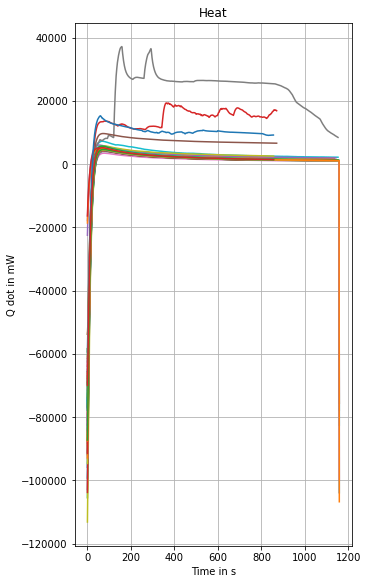

In [26]:
def plot():
    client = MongoClient('localhost:27017')
    db = client.hiwi
    qdot_data = list(db.production_steps.find({"substep": "qdot"}))

    fig, axs = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(5, 8))

    axs.set_title('Heat')
    axs.set_xlabel('Time in s')
    axs.set_ylabel('Q dot in mW')
    axs.grid()

    for i in range(len(qdot_data)):
        if qdot_data[i]["readings"] != []:
            df = pd.DataFrame(qdot_data[i]["readings"])
            axs.plot(pd.DataFrame(qdot_data[i]["readings"][:])["qdot_value"])
            # axs.plot(scipy.signal.savgol_filter(np.diff(pd.DataFrame(qdot_data[i]["readings"][2500:10000])["qdot_value"]), 499, 3))
    plt.show()


plot()

In [27]:
def plot_class(class_i):
    client = MongoClient('localhost:27017')
    db = client.hiwi
    qdot_data = list(db.production_steps.find({"substep": "qdot"}))

    fig, axs = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(5, 8))

    axs.set_title('Heat')
    axs.set_xlabel('Time in s')
    axs.set_ylabel('Q dot in mW')
    axs.grid()

    for i in range(len(qdot_data)):
        if qdot_data[i]["readings"] != [] and qdot_data[i]["cell_id"] in class_i:
            df = pd.DataFrame(qdot_data[i]["readings"])
            axs.plot(pd.DataFrame(qdot_data[i]["readings"][:])["qdot_value"])
            # axs.plot(scipy.signal.savgol_filter(np.diff(pd.DataFrame(qdot_data[i]["readings"][2500:10000])["qdot_value"]), 499, 3))
    plt.show()

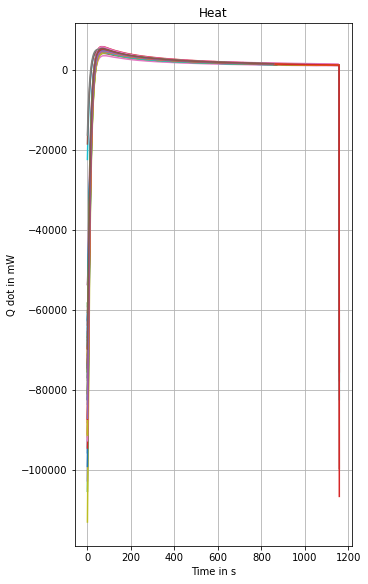

In [28]:
plot_class(class_0)

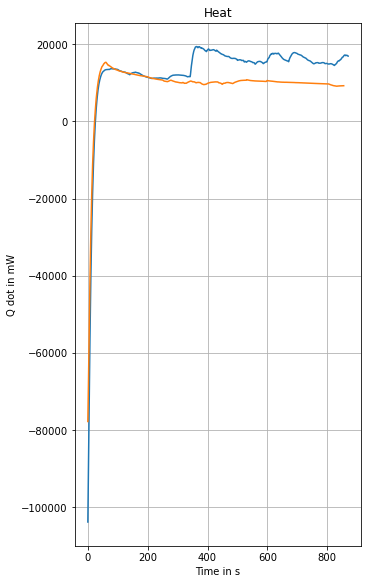

In [29]:
plot_class(class_1)

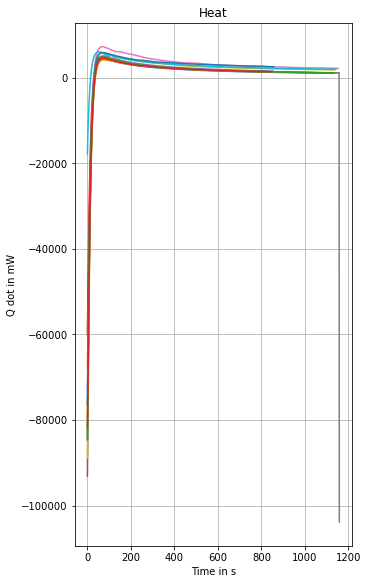

In [30]:
plot_class(class_2)

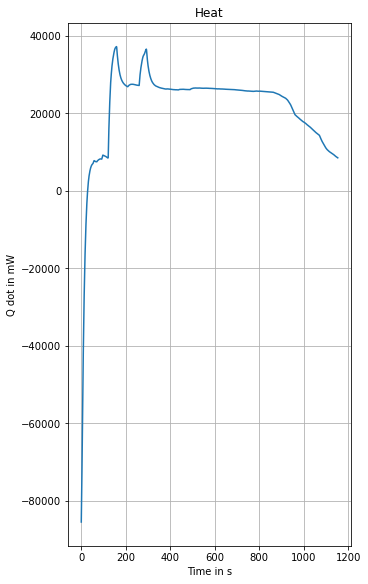

In [31]:
plot_class(class_3)

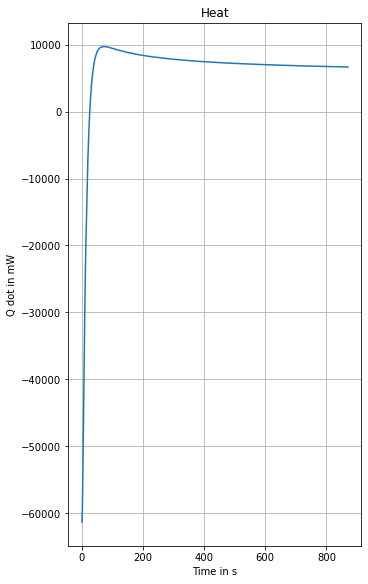

In [32]:
plot_class(class_4)